In [1]:
#-*- coding: utf-8 -*-

<img align="right" style="max-width: 200px; height: auto" src="images/cfds_logo.png">

###  Lab 05 - "Supervised Deep Learning"

Chartered Financial Data Scientist (CFDS), Spring Term 2019

In the fourth lab you learned about how to utilize an **unsupervised** machine learning technique namely the **K-Means Clustering** algorithm. 

In this fifth lab we will learn how to implement, train and apply our first **Artificial Neural Network (ANN)** using a Python library named **'PyTorch'**. PyTorch is an open-source machine learning library for Python, used for a variety of applications such as image classification and natural language processing.

We will use the implemented neural network to classify images of handwrittend digits (i.e., data without defined categories or groups).

<img align="center" style="max-width: 700px" src="images/classification.png">

Pls. don't hesitate to contact me (via marco.schreyer@unisg.ch) in case of any difficulties with the lab content or any questions.

### Lab Objectives:

After today's lab you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Artificial Neural Networks (ANNs)**.
> 2. Know how to use Python's **PyTorch library** to train and evaluate neural network based models.
> 3. Understand how to apply neural networks to **classify images** of handwritten digits.
> 4. Know how to **interpret the detection results** of the network as well as its **reconstruction loss**.

### Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the PyTorch, Numpy, Sklearn, Matplotlib, Seaborn and a few utility libraries throughout the course of this lab:

In [2]:
# import standard python libaries
import os
from datetime import datetime
import numpy as np

Import python machine / deep learning libraries:

In [3]:
# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

Import the sklearn classification metrics:

In [4]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import python plotting libraries:

In [5]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [6]:
%matplotlib inline

Create notebook folder structure to store the data as well as the trained neural network models:

In [7]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

### Step 1.0: Dataset Download and Data Assessment

The **MNIST database** (**M**odified **N**ational **I**nstitute of **S**tandards and **T**echnology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning.

<img align="center" style="max-width: 500px; height: 300px" src="images/mnist.png">

(Source: https://en.wikipedia.org/wiki/MNIST_database)

Further details on the dataset can be obtained via: *LeCun, Y., 1998. "The MNIST database of handwritten digits", ( http://yann.lecun.com/exdb/mnist/ )."*

The MNIST database contains 60,000 training images and 10,000 testing images. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.
Let's download, transform and inspect the training images of the dataset.

First we will define the directory we aim to store the training data:

In [8]:
train_path = './data/train_mnist'

Now, let's download the training data accordingly:

In [9]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
mnist_train_data = torchvision.datasets.MNIST(root=train_path, train=True, transform=transf, download=True)

100.1%

Extracting ./data/train_mnist/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

113.5%

Extracting ./data/train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Verify the volume of images downloaded:

In [10]:
# get the length of the training data
len(mnist_train_data)

60000

Furthermore, let's investigate a couple of the training images:

In [11]:
# set (random) image id
image_id = 7779

# retrieve image exhibiting the image id
mnist_train_data[image_id]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Ok, that doesn't seem right :). Let's now seperate the image from its label information:

In [12]:
mnist_train_image, mnist_train_label = mnist_train_data[image_id]

Great, let's now visually inspect our sample image: 

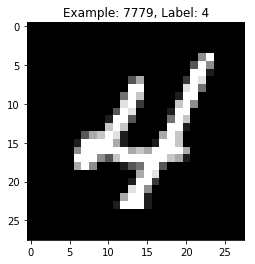

In [13]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(mnist_train_label)))

# plot mnist handwritten digit sample
plt.imshow(trans(mnist_train_image), cmap='gray')

Awsome, right? Let's now decide on were we want to store the evaluation data:

In [14]:
eval_path = './data/eval_mnist'

And download the evaluation data accordingly:

In [15]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
mnist_eval_data = torchvision.datasets.MNIST(root=eval_path, train=False, transform=transf, download=True)

0.0%

100.1%

Extracting ./data/eval_mnist/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

113.5%

Extracting ./data/eval_mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/eval_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/eval_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Step 2.0 Neural Network Implementation

In this section we will implement the architecture of the neural network we want to utilize in order to classify the MNIST images of handwritten digits.

<img align="center" style="max-width: 900px" src="images/process.png">

Our neural network, which we name 'MNISTNet' consists of three ** fully-connected layers** (including an “input layer” and two hidden layers). Furthermore, the MNISTNet should encompass the following number of neurons per layer: 100 (layer 1), 50 (layer 2) and 10 (layer 3). Meaning the first layer consists of 100 neurons, the second layer of 50 neurons and third layer of 10 neurons (the number of digit classes we aim to classify.

In [16]:
# implement the MNISTNEt network architecture
class MNISTNet(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet, self).__init__()
        
        # specify fc layer 1 - in 28*28, out 100
        self.linear1 = nn.Linear(28*28, 100, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 100, out 50
        self.linear2 = nn.Linear(100, 50, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 50, out 10
        self.linear3 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

You may have noticed that we applied an additional operator, referred to as **'Softmax'** to the third layer of our neural network.

The **softmax function**, also known as the normalized exponential function is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities. 

That is, prior to applying softmax, some vector components could be negative, or greater than one; and might not sum to 1; but after application of the softmax, each component will be in the interval $(0,1)$, and the components will add up to 1, so that they can be interpreted as probabilities. In general, the softmax function $\sigma :\mathbb {R} ^{K}\to \mathbb {R} ^{K}$ is defined by the formula:

<center> $\sigma (\mathbf {z} )_{i}=\ln ({e^{z_{i}} / \sum _{j=1}^{K}e^{z_{j}}})$ </center>

for $i = 1, …, K$ and ${\mathbf {z}}=(z_{1},\ldots ,z_{K})\in \mathbb {R} ^{K}$ (Source: https://en.wikipedia.org/wiki/Softmax_function ). 

Given a three-class example below, the scores of the distinct predicted classes $c_i$ are computed from the forward propagation of the network. We then take the softmax and obtain the probabilities as shown:

<img align="center" style="max-width: 600px" src="images/softmax.png">

The output of the softmax describes the probability (or if you may, the confidence) of the neural network that a particular sample belongs to a certain class. Thus, for the first example above, the neural network assigns a confidence of 0.49 that it is a 'three', 0.49 that it is a 'four', and 0.03 that it is an 'eight'. The same goes for each of the samples above.

Now, that we have implemented our first neural network we are ready to instantiate a network model to be trained:

In [17]:
model = MNISTNet()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [18]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



Looks like intended? Brilliant!

Now that we have implemented the MNISTNet we are ready to train the network. However, prior to starting the training, we need to define an apropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given handwritten digit image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|C - f_\theta(X)\|$ over all training images in the MNIST dataset. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the **'Negative Log Likelihood (NLL)'** loss, defined by:

<center> $\mathcal{L}^{NLL}_{\theta} (c_i, \hat c_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $, </center>

for a set of $n$-MNIST images $x^{i}$, $i=1,...,n$ and their respective predicted class labels $\hat{c}^{i}$. This is summed for all the correct classes. 

Let's have a look at a brief example:

<img align="center" style="max-width: 600px" src="images/loss.png">

During trainig the NLL loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$. Luckily, an implementation of the NLL loss is already available in PyTorch! It can be instantiated "off-the-shelf" via the execution of the following PyTorch command:

In [19]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Stochastic Gradient Descent (SGD) optimization** and set the learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to degree of classification error (the MSE loss).

In [20]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three ANN building blocks let's take some time to review the `MNISTNet` model definition as well as the `loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

### Step 3.0. Training the Neural Network Model

In this section, we will train our neural network model (as implemented in section above) using the transformed images of handwritten digits. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

#### Step 3.1. Preparing the Network Training

So far we have pre-processed the dataset, implemented the ANN and defined the classification error. Let's now start to train a corresponding model for **20 epochs** and a **mini-batch size of 128** MNIST images per batch. This implies that the whole dataset will be fed to the ANN 20 times in chunks of 128 images yielding to **469 mini-batches** (60.000 images / 128 images per mini-batch) per epoch.

In [21]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specifiy and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [22]:
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, batch_size=mini_batch_size, shuffle=True)

#### Step 3.2. Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows: 

>1. do a forward pass through the MNISTNet network, 
>2. compute the negative log likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the MNISTNet network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our ANN model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [23]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(mnist_train_dataloader):
        
        # convert images to torch tensor
        images = Variable(images)
        
        # convert labels to torch tensor
        labels = Variable(labels)
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'mnist_model_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20190625-12:51:38] epoch: 0 train-loss: 2.3013061826417185
[LOG 20190625-12:51:44] epoch: 1 train-loss: 2.2856762414293756
[LOG 20190625-12:51:50] epoch: 2 train-loss: 2.267857650703967
[LOG 20190625-12:51:56] epoch: 3 train-loss: 2.2470806148260642
[LOG 20190625-12:52:02] epoch: 4 train-loss: 2.2216816792355925
[LOG 20190625-12:52:10] epoch: 5 train-loss: 2.189442332619543
[LOG 20190625-12:52:19] epoch: 6 train-loss: 2.148083614642178
[LOG 20190625-12:52:28] epoch: 7 train-loss: 2.0947291744289114
[LOG 20190625-12:52:34] epoch: 8 train-loss: 2.025753252033486
[LOG 20190625-12:52:40] epoch: 9 train-loss: 1.937938778639348
[LOG 20190625-12:52:47] epoch: 10 train-loss: 1.8299454483650386
[LOG 20190625-12:52:53] epoch: 11 train-loss: 1.704329242838471
[LOG 20190625-12:53:01] epoch: 12 train-loss: 1.5671429303663371
[LOG 20190625-12:53:08] epoch: 13 train-loss: 1.4274694868750664
[LOG 20190625-12:53:14] epoch: 14 train-loss: 1.294494072003151
[LOG 20190625-12:53:20] epoch: 15 train-lo

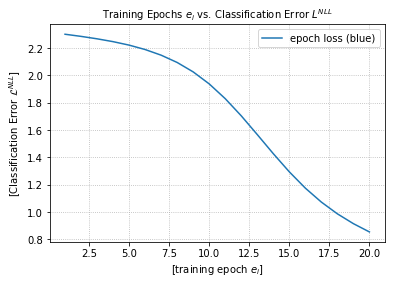

In [24]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could definitly train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

### Step 4.0. Evaluation of the Trained Neural Network Model

Prior to evaluating our model let's load the best performing model. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [25]:
# restore pre-trained model snapshot
best_model_name = "mnist_model_epoch_39.pth"

# init pre-trained model class
best_model = MNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name)))

Let's inspect if the model was loaded successfully: 

In [26]:
# set model in evaluation mode
best_model.eval()

MNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In order to evaluate our trained model we need to feed the MNIST images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [27]:
mnist_eval_dataloader = torch.utils.data.DataLoader(mnist_eval_data, batch_size=10000, shuffle=True)

We will now evaluate the trained model using the same mini batch approach as we did throughout the network training and derive the mean negative log likelihood loss of the mini-batches:

In [28]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(mnist_eval_dataloader):

    # convert images to torch tensor
    images = Variable(images)

    # convert labels to torch tensor
    labels = Variable(labels)

    # run forward pass through the network
    output = model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20190625-12:53:46] eval-loss: 0.8002436757087708


Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect the a few sample predictions in order to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [29]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
mnist_eval_image, mnist_eval_label = mnist_eval_data[image_id]

Let's now inspect the true class of the image we selected:

In [30]:
mnist_eval_label

1

Ok, the randomly selected image should contain a two (2). Let's inspect the image accordingly:

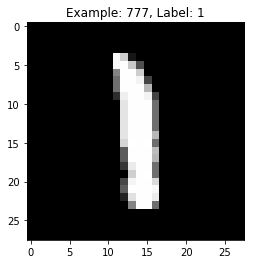

In [31]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(mnist_eval_label)))

# plot mnist handwritten digit sample
plt.imshow(trans(mnist_eval_image), cmap='gray')

Ok, let's compare the true label with the prediction of our model:

In [32]:
model(Variable(mnist_eval_image))

tensor([[-8.1970, -0.2564, -3.7395, -3.2872, -5.1233, -3.9684, -5.6052, -3.6270,
         -2.3816, -4.0610]], grad_fn=<LogSoftmaxBackward>)

We can even determine the likelihood of the most probable class:

In [33]:
torch.argmax(model(Variable(mnist_eval_image)), dim=1).item()

1

Let's now obtain the predictions for all the handwritten digit images of the evaluation data:

In [34]:
predictions = torch.argmax(model(Variable(mnist_eval_data.data.float())), dim=1)

Furthermore, let's obtain the overall classifcation accuracy:

In [35]:
metrics.accuracy_score(mnist_eval_data.targets, predictions)

0.799

Let's also inspect the confusion matrix to determine major sources of missclassification

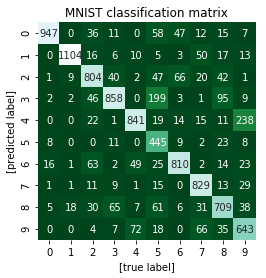

In [36]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(mnist_eval_data.targets, predictions)

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model is confusiong the digits 3 and 5 as well the digits 9 and 4 quite often. When looking at the corresponding images this makes sense right?   

### Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Train the network a couple more epochs and evaluate its prediction accuracy.**

> Increase the number of training epochs up to 50 epochs and re-run the network training. Load and evaluate the model exhibiting the lowest training loss. What kind of behavior in terms of prediction accuracy can be observed with increasing the training epochs?

**2. Evaluaton of "shallow" vs. "deep" neural network architectures.**

> In addition to the architecture of the lab notebook, evaluate further (more shallow as well as more deep) neural network architectures by (1) either removing or adding layers to the network and/or (2) increasing/decreasing the number of neurons per layer. Train a model (using the architectures you selected) for at least 50 training epochs. Analyse the prediction performance of the trained models in terms of training time and prediction accuracy. 

### Lab Summary:

In this fifth lab, a step by step introduction into **design, implementation, training and evaluation** of neural networks to classify images of handwritten digits is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, more deep and tailored **neural networks**.

You may want to execute the content of your lab outside of the jupyter notebook environment e.g. on compute node or server. The cell below converts the lab notebook into a standalone and executable python script.

In [37]:
!jupyter nbconvert --to script cfds_lab_05.ipynb

[NbConvertApp] Converting notebook cfds_lab_05.ipynb to script
[NbConvertApp] Writing 23501 bytes to cfds_lab_05.py


**Note:** In order to execute the statement above and convert your lab notebook to a regular Python script you first need to install the nbconvert Python package e.g. using the pip package installer. 